In [163]:
import pandas as pd
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.notebook_repr_html", True)
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")
pd.reset_option("display.max_colwidth")

In [164]:
weights_df = pd.read_csv("../1. Inspect, Clean and Validate Dataset/CleanedData/Cleaned_WeightsAndCalories.csv")
nutrition_df = pd.read_csv("../1. Inspect, Clean and Validate Dataset/CleanedData/Cleaned_NutritionalData.csv")
strava_df = pd.read_csv("../1. Inspect, Clean and Validate Dataset/CleanedData/Cleaned_Strava.csv")

We need to remove the rows with a high carbohydrate intake. Carbohydrates are known for their ability to carry water.

1. remove the rows with carb content over x grams
    - we may also need to aggregate the data so there is only one date
    - nutritional = nutritional.groupby["Date"]["Carbohydrates (g)"].sum()
2. Merge with weights_df. we need to drop all rows which dont align with the nutritional df
    - newdf = pd.merge(weights_df, nutritional_df, left_on="Date", right_on="Date", how="right")

In [165]:
nutrition_df["Date"] = pd.to_datetime(nutrition_df["Date"], errors="coerce", format="%Y-%m-%d")

nutrition_df["Total Calories In"] = np.round(nutrition_df.groupby("Date")["Calories"].transform("sum"))
nutrition_df["Total Fat In (g)"] = nutrition_df.groupby("Date")["Fat (g)"].transform("sum")
nutrition_df["Total Carbohydrates In (g)"] = nutrition_df.groupby("Date")["Carbohydrates (g)"].transform("sum")
nutrition_df["Total Protein In (g)"] = nutrition_df.groupby("Date")["Protein (g)"].transform("sum")

nutrition_df = nutrition_df[["Date", "Total Calories In", "Total Fat In (g)", "Total Carbohydrates In (g)", "Total Protein In (g)"]]
nutrition_df = nutrition_df.drop_duplicates(subset="Date").reset_index(drop=True)
total_records = len(nutrition_df)

# Drop rows over x total carbs
x_carbohydrates = 100

excluded_nutrition_df = nutrition_df[nutrition_df["Total Carbohydrates In (g)"] > x_carbohydrates]
excluded_nutrition_df = excluded_nutrition_df.reset_index(drop=True)
excluded_nutrition_df = excluded_nutrition_df[["Date", "Total Calories In", "Total Carbohydrates In (g)"]]

nutrition_df = nutrition_df[nutrition_df["Total Carbohydrates In (g)"] <= x_carbohydrates]
nutrition_df = nutrition_df.reset_index(drop=True)
total_days_under_x_carbs = len(nutrition_df)
print(f"{total_records=}, {total_days_under_x_carbs=}")
# nutrition_df.sort_values("Date")

total_records=1431, total_days_under_x_carbs=687


In [166]:
# Drop rows over x total carbs
x_carbohydrates = 100
nutrition_df = nutrition_df[nutrition_df["Total Carbohydrates In (g)"] <= x_carbohydrates]
nutrition_df = nutrition_df.reset_index(drop=True)
total_days_under_x_carbs = len(nutrition_df)
print(total_days_under_x_carbs)
# nutrition_df

687


Merge Nutrition_df with weights_df

In [167]:
weights_df = weights_df[["Date", "Weight, kg", "Calories In"]]
weights_df["Date"] = pd.to_datetime(weights_df["Date"], errors="coerce", format="%d/%m/%Y")
master_df = pd.merge(weights_df, nutrition_df, left_on="Date", right_on="Date", how="inner")
# Some values in weights_df were removed because they contained missing data for a rows- all of the missing rows are in ./DataInput/Weights and Total Cal Intake/Missing data dates.csv
# In my own personal spreadsheet I estimate these
master_df = master_df[["Date", "Weight, kg", "Total Calories In", "Total Carbohydrates In (g)"]]
num_weight_nutritional_records = len(master_df)
print(f"{num_weight_nutritional_records=}")
# master_df.sort_values("Date")

num_weight_nutritional_records=508


We now need to merge master_df with strava_df. This will let us identify days with no exercise vs days with exercise

In [168]:
strava_df["Activity Date"] = pd.to_datetime(strava_df["Activity Date"], errors="coerce", format="%Y-%m-%d")

strava_df = strava_df[["Activity Date", "Calories", "Did Exercise"]]
strava_df_len = len(strava_df)

strava_df = strava_df.groupby("Activity Date")["Calories"].sum() # Condense all records into one row, with the calorie count being the sum of all relevant records
strava_df = strava_df.rename("Exercise Calories Burned")
strava_df = strava_df.to_frame()
strava_df["Did Exercise"] = 1
# type(unique_strava_df)
strava_df

,Exercise Calories Burned,Did Exercise
Activity Date,,
2020-06-03,0.0,1
2020-06-07,0.0,1
2020-06-15,0.0,1
2020-06-16,0.0,1
2020-06-21,0.0,1
...,...,...
2025-08-21,156.0,1
2025-08-23,180.0,1
2025-08-24,126.0,1


Merge strava_df with master_df

In [169]:
master_df = pd.merge(master_df, strava_df, left_on="Date", right_on="Activity Date", how="left")

Fill replace NaN values in master_df["Did Exercise"] with 0. 0 signifies no exercise that day, 1 signifies exercise occurred that day

In [170]:
master_df["Did Exercise"] = master_df["Did Exercise"].fillna(0)
master_df.head()

,Date,"Weight, kg",Total Calories In,Total Carbohydrates In (g),Exercise Calories Burned,Did Exercise
0,2020-12-21,51.4,715.0,78.0,NaN,0.0
1,2021-02-09,53.3,785.0,98.9,NaN,0.0
2,2021-03-01,54.7,280.0,64.0,NaN,0.0
3,2021-04-18,56.2,760.0,90.2,NaN,0.0
4,2022-04-09,60.5,600.0,80.8,0.0,1.0


Now, if a row has 0 calories burned, we can distinguish whether any exercise was actually carried out that day by looking in the "Did Exercise" column.

We need to calculate daily weight change, but we need to remember that we don't have records for every day.

If for each day0:
    day1_weight_change = day1["Weight, kg"] - day0["Weight, kg"]
then we need to be sure that day1 exists

In [171]:
dwc_calculation = master_df.copy()
dwc_calculation = dwc_calculation.sort_values("Date").reset_index(drop=True)
dwc_calculation["Daily Weight Change"] = np.nan

In [172]:
for i in range(1, len(dwc_calculation)):
	current_date = dwc_calculation.loc[i, "Date"]
	#Date is of type <class 'pandas._libs.tslibs.timestamps.Timestamp'>
	previous_date = dwc_calculation.loc[i-1, "Date"]
	if ((current_date - previous_date).days != 1):
		# There are a lot of rows that count as missing- a lot of this is because I have removed rows where total carb count for that day exceeds 100. Other times this is because of missing data and rows in the dataset- some of these rows contain data that i have estimated
		# This has removed far more rows than I thought it would have which has made me think that there is an issue with the logic flow of the code
		print(f"Missing data between: {i} {current_date} - {i-1} {previous_date} != 1")
		continue
	current_weight = dwc_calculation.loc[i, "Weight, kg"]
	previous_weight = dwc_calculation.loc[i-1, "Weight, kg"]
	dwc_calculation.loc[i, "Daily Weight Change"] = current_weight - previous_weight

master_df["Daily Weight Change"] = dwc_calculation["Daily Weight Change"]
# master_df.sort_values("Date")[["Date", "Weight, kg", "Daily Weight Change"]]
# master_df

Missing data between: 1 2021-02-09 00:00:00 - 0 2020-12-21 00:00:00 != 1
Missing data between: 2 2021-03-01 00:00:00 - 1 2021-02-09 00:00:00 != 1
Missing data between: 3 2021-04-18 00:00:00 - 2 2021-03-01 00:00:00 != 1
Missing data between: 4 2022-04-09 00:00:00 - 3 2021-04-18 00:00:00 != 1
Missing data between: 5 2023-04-27 00:00:00 - 4 2022-04-09 00:00:00 != 1
Missing data between: 6 2023-05-05 00:00:00 - 5 2023-04-27 00:00:00 != 1
Missing data between: 7 2023-05-09 00:00:00 - 6 2023-05-05 00:00:00 != 1
Missing data between: 15 2023-05-18 00:00:00 - 14 2023-05-16 00:00:00 != 1
Missing data between: 17 2023-05-22 00:00:00 - 16 2023-05-19 00:00:00 != 1
Missing data between: 18 2023-05-25 00:00:00 - 17 2023-05-22 00:00:00 != 1
Missing data between: 29 2023-06-06 00:00:00 - 28 2023-06-04 00:00:00 != 1
Missing data between: 34 2023-06-14 00:00:00 - 33 2023-06-10 00:00:00 != 1
Missing data between: 36 2023-06-18 00:00:00 - 35 2023-06-15 00:00:00 != 1
Missing data between: 37 2023-06-21 00:

Remove rows that have missing values for "Daily Weight Change"

In [173]:
dropped_rows = master_df[master_df["Daily Weight Change"].isna()]
master_df = master_df.dropna(subset=["Daily Weight Change"]).reset_index(drop=True)
# At this point there is no na values within the "daily weight change" column in master_df
master_df

,Date,"Weight, kg",Total Calories In,Total Carbohydrates In (g),Exercise Calories Burned,Did Exercise,Daily Weight Change
0,2023-05-10,60.8,2328.0,46.1,NaN,0.0,0.5
1,2023-05-11,60.6,2564.0,6.8,151.0,1.0,-0.2
2,2023-05-12,60.4,2471.0,16.9,51.0,1.0,-0.2
3,2023-05-13,60.7,1791.0,28.3,NaN,0.0,0.3
4,2023-05-14,59.8,2361.0,22.8,NaN,0.0,-0.9
...,...,...,...,...,...,...,...
354,2025-08-15,66.9,2956.0,49.7,272.0,1.0,-0.3
355,2025-08-20,66.2,2892.0,55.5,421.0,1.0,-0.1
356,2025-08-21,66.3,2343.0,52.2,156.0,1.0,0.1
357,2025-08-25,66.7,2898.0,76.8,282.0,1.0,-0.1


Remove outliers from the "Exercise Calories Burned" column

I did exercise on 359 days and burned calories through exercise on 278 days


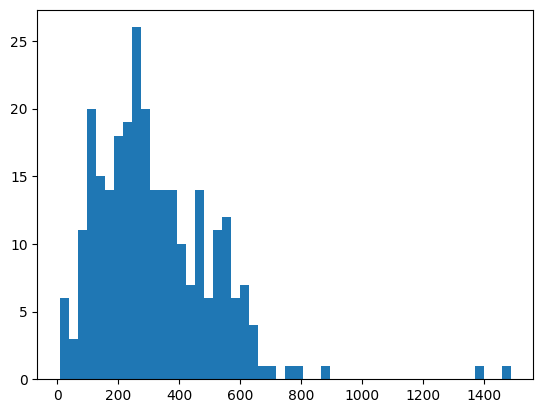

Skew: 1.6313944187369118 / Kurtosis: 6.563112219296368


In [174]:
did_exercise = master_df[master_df["Exercise Calories Burned"] > 0].copy()
print(f"I did exercise on {len(master_df["Did Exercise"])} days and burned calories through exercise on {len(did_exercise)} days")
plt.hist(did_exercise["Exercise Calories Burned"], bins=50)
plt.show()
plt.close()

skew_score = skew(did_exercise["Exercise Calories Burned"])
kurtosis_score = kurtosis(did_exercise["Exercise Calories Burned"])
print(f"Skew: {skew_score} / Kurtosis: {kurtosis_score}")

Distribution of Column: "Exercise Calories Burned"

Shape: Right, positively skewed. Most values range from 150-600, with a long right tail up to 1400

Mode: Tallest bars are at ~250

Spread: Majority of the data values are between 150-600 calories, however there are some more extreme values at 800, 1000 and 1400+

Outliers: A few high data points with values that are multiple times the median

Skewness Score: ~1.7 (Right skew)

Kurtosis Score: ~6.3 (Greater than 3, high peak and heavy tails)

I'll attempt to remove outliers with the IQR*1.5 rule

lower: -182.875 | upper: 802.125


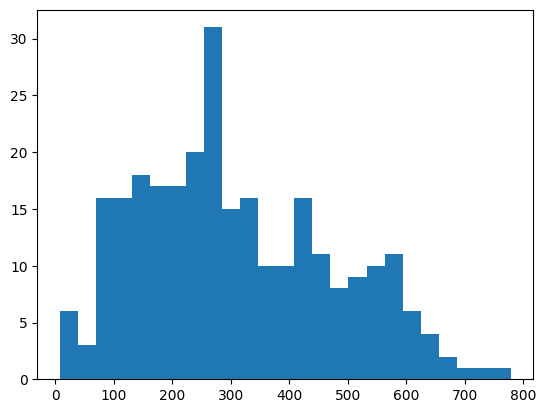

New Skew: 0.4302828988229492 / New Kurtosis: -0.5918483202259162


In [175]:
Q1 = did_exercise["Exercise Calories Burned"].quantile(0.25)
Q3 = did_exercise["Exercise Calories Burned"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"lower: {lower_bound} | upper: {upper_bound}")
# Don't want to remove rows with a 0 exercise calories burned count that did not do exercise
did_exercise = did_exercise[
	((did_exercise["Exercise Calories Burned"] >= lower_bound) & (did_exercise["Did Exercise"] == 1)) &
	((did_exercise["Exercise Calories Burned"] <= upper_bound) & (did_exercise["Did Exercise"] == 1))
]

plt.hist(did_exercise["Exercise Calories Burned"], bins=25)
plt.show()
plt.close()

skew_score = skew(did_exercise["Exercise Calories Burned"])
kurtosis_score = kurtosis(did_exercise["Exercise Calories Burned"])
print(f"New Skew: {skew_score} / New Kurtosis: {kurtosis_score}")

master_df["Exercise Calories Burned"] = did_exercise["Exercise Calories Burned"]

In [176]:
master_df

,Date,"Weight, kg",Total Calories In,Total Carbohydrates In (g),Exercise Calories Burned,Did Exercise,Daily Weight Change
0,2023-05-10,60.8,2328.0,46.1,NaN,0.0,0.5
1,2023-05-11,60.6,2564.0,6.8,151.0,1.0,-0.2
2,2023-05-12,60.4,2471.0,16.9,51.0,1.0,-0.2
3,2023-05-13,60.7,1791.0,28.3,NaN,0.0,0.3
4,2023-05-14,59.8,2361.0,22.8,NaN,0.0,-0.9
...,...,...,...,...,...,...,...
354,2025-08-15,66.9,2956.0,49.7,272.0,1.0,-0.3
355,2025-08-20,66.2,2892.0,55.5,421.0,1.0,-0.1
356,2025-08-21,66.3,2343.0,52.2,156.0,1.0,0.1
357,2025-08-25,66.7,2898.0,76.8,282.0,1.0,-0.1


Remove outliers from "Daily Weight Change" column

There are 359 rows that have records for consecutive days


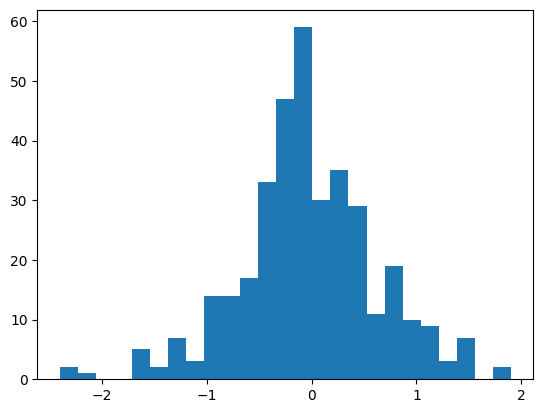

Skew: -0.17096379376975548 / Kurtosis: 0.9919971549534363


In [177]:
dwc_df = master_df.copy()
print(f"There are {len(dwc_df)} rows that have records for consecutive days")
plt.hist(dwc_df["Daily Weight Change"], bins=25)
plt.show()
plt.close()

skew_score = skew(dwc_df["Daily Weight Change"].dropna())
kurtosis_score = kurtosis(dwc_df["Daily Weight Change"].dropna())
print(f"Skew: {skew_score} / Kurtosis: {kurtosis_score}")

Distribution of Column: "Daily Weight Change"

Shape: Roughly symmetrical

Mode: Mode of 0

Spread: Most values are between +/-1.5. Much tighter spread than the previous distribution for "Exercise Calories Burned"

Outliers: Some potential outliers on the left tail, (below -2)

Skewness Score: ~-0.23 (Left skew)

Kurtosis Score: ~0.98 (Greater than 0, less than 3, higher peak and with some tails)

I'll attempt to remove outliers with the IQR*1.5 rule

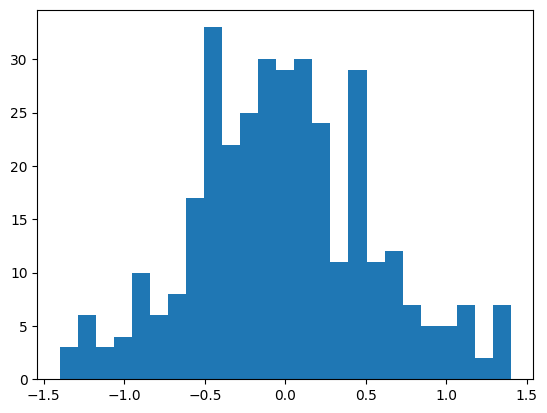

Skew: -0.17096379376975548 / Kurtosis: 0.9919971549534363


In [178]:
Q1 = dwc_df["Daily Weight Change"].quantile(0.25)
Q3 = dwc_df["Daily Weight Change"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dailyweightchanges_outofbounds = pd.DataFrame(columns=list(dwc_df.columns))
# dailyweightchanges_outofbounds.columns = dwc_df.columns
for i, row in dwc_df.iterrows():
    if not ((row["Daily Weight Change"] >= lower_bound) & (row["Daily Weight Change"] <= upper_bound)):
        dailyweightchanges_outofbounds.loc[len(dailyweightchanges_outofbounds)] = list(row)

weight_changes = dwc_df[(dwc_df["Daily Weight Change"] >= lower_bound) & (dwc_df["Daily Weight Change"] <= upper_bound)]

plt.hist(weight_changes["Daily Weight Change"], bins=25)
plt.show()
plt.close()

skew_score = skew(dwc_df["Daily Weight Change"])
kurtosis_score = kurtosis(dwc_df["Daily Weight Change"])
print(f"Skew: {skew_score} / Kurtosis: {kurtosis_score}")

master_df["Daily Weight Change"] = dwc_df["Daily Weight Change"]

Are there any rows with na values that we don't know about?

In [179]:
# There are some rows still marked as na
na_rows = master_df[master_df.isna().any(axis=1)]

Split the data set in two: one dataframe for did exercise, one for no exercise

In [180]:
did_exercise = master_df.copy()
did_exercise = did_exercise[did_exercise["Did Exercise"] == 1]
no_exercise = master_df.copy()
no_exercise = no_exercise[no_exercise["Did Exercise"] == 0]
print(f"I did exercise on {len(did_exercise)} days and no exercise on {len(no_exercise)} days")

I did exercise on 296 days and no exercise on 63 days


Adding a threshold to the number of calories burned to count the exercise in the study

In [181]:
exercise_baseline_cals_burned = 150
did_exercise = did_exercise[did_exercise["Exercise Calories Burned"] > exercise_baseline_cals_burned]
print(f"With the baseline added, I did exercise on {len(did_exercise)} days.")

With the baseline added, I did exercise on 224 days.


Sorting the rows by calories, grouping them into bins of 10 calories

In [182]:
did_min_val = did_exercise["Total Calories In"].min()
did_max_val = did_exercise["Total Calories In"].max()
no_min_val = no_exercise["Total Calories In"].min()
no_max_val = no_exercise["Total Calories In"].max()
min_val = min(did_min_val, no_min_val)
max_val = max(did_max_val, no_max_val)

bin_size = 10
bins = np.arange(start=min_val, stop=max_val + 10, step=bin_size)

# Optional: create labels like "0-10", "11-20", ...
labels = [f"{int(bins[i])}-{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

# Create the binned column
no_exercise.loc[:, "Calories Group"] = pd.cut(no_exercise["Total Calories In"], bins=bins, labels=labels, include_lowest=True)
did_exercise.loc[:, "Calories Group"] = pd.cut(did_exercise["Total Calories In"], bins=bins, labels=labels, include_lowest=True)

In [183]:
did_exercise = did_exercise[["Date", "Daily Weight Change", "Calories Group", "Exercise Calories Burned", "Did Exercise"]].reset_index(drop=True)
did_exercise.to_csv("./Data Sets/Did Exercise Data Set.csv")

In [184]:
no_exercise = no_exercise[["Date", "Daily Weight Change", "Calories Group", "Did Exercise"]].reset_index(drop=True)
no_exercise.to_csv("./Data Sets/No Exercise Data Set.csv")

In [185]:
no_ex_valuecounts = no_exercise["Calories Group"].value_counts().to_frame()
did_ex_valuecounts = did_exercise["Calories Group"].value_counts().to_frame()
valuecounts_df = pd.merge(no_ex_valuecounts, did_ex_valuecounts, on="Calories Group", how="inner", suffixes=["No", "Did"])

valuecounts_df["Maximum"] = np.minimum(valuecounts_df["countNo"], valuecounts_df["countDid"])
valuecounts_df = valuecounts_df[valuecounts_df["Maximum"] > 0].reset_index(drop=True)
valuecounts_df.to_csv("./Data Sets/calories_value_counts.csv", index=False)
valuecounts_df

,countNo,countDid,Maximum
0,3,8,3
1,3,6,3
2,3,6,3
3,3,13,3
4,2,1,1
5,2,1,1
6,2,2,2
7,2,1,1
8,2,11,2
9,2,5,2


In [186]:
all_df = pd.merge(did_exercise, no_exercise, on=["Date", "Calories Group", "Did Exercise"], how="outer")
all_df = all_df.reset_index(drop=True)
all_df.to_csv("./Data Sets/exercise_study_rows.csv", index=False)